In [3]:
import keras
import tensorflow as tf

In [12]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom", name="Attention")
class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer=RandomNormal(mean=0., stddev=1.))
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros')
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_sequences:
            return input_shape
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({"return_sequences": self.return_sequences})
        return config


In [13]:
from tensorflow.keras.models import load_model



In [14]:

# Ensure the Attention class is available during the loading process
custom_objects = {'Attention': Attention}


In [15]:
# Load the model
lstm_model = load_model('my_lstm_model.keras', custom_objects=custom_objects)


C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop

# Ensure the Attention class is available during the loading process
custom_objects = {'Attention': Attention}



In [17]:
# Load the model without compiling
lstm_model = load_model('my_lstm_model.keras', custom_objects=custom_objects, compile=False)



In [18]:
# Recreate the optimizer
optimizer = RMSprop()



In [19]:
# Compile the model with the recreated optimizer
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertForSequenceClassification
import torch
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer
import shap
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from transformers import pipeline
from tensorflow.keras.models import load_model

In [22]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahmedma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ahmedma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ahmedma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
# Read the dataset
#df = pd.read_csv('LLM_Datasets/Training_Essay_Data.csv')
df = pd.read_csv('Training_Essay_Data.csv', encoding='latin1')

In [25]:
# Exploratory Data Analysis (EDA)
print(df.head())
print(df.info())
print(df['generated'].value_counts())


                                                text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27537 entries, 0 to 27536
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27537 non-null  object
 1   generated  27537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 430.4+ KB
None
generated
0    17508
1    10029
Name: count, dtype: int64


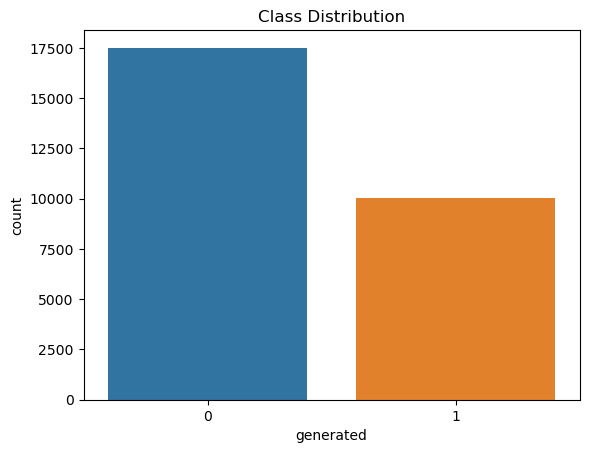

In [26]:
# Visualize class distribution
sns.countplot(x='generated', data=df)
plt.title('Class Distribution')
plt.show()


In [27]:

# Data Preprocessing and Cleaning
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text


In [28]:
df['clean_text'] = df['text'].apply(clean_text)




In [29]:
# Tokenization, stopwords removal, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [30]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens



In [31]:
df['tokens'] = df['clean_text'].apply(preprocess_text)



In [32]:
# Convert text data into numerical representations: TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])



In [33]:
# Define features (X) and target variable (y)
X = tfidf_matrix
y = df['generated']


In [34]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [37]:
# Tokenize and pad text data for neural network model
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])

In [38]:
X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = tf.keras.preprocessing.sequence.pad_sequences(X_seq, padding='post')



In [39]:
X_train_pad, X_temp_pad, y_train, y_temp = train_test_split(X_pad, y, test_size=0.3, random_state=42)
X_val_pad, X_test_pad, y_val, y_test = train_test_split(X_temp_pad, y_temp, test_size=0.5, random_state=42)


In [40]:
# Evaluate the LSTM model on the test set
y_pred_nn = (lstm_model.predict(X_test_pad) > 0.5).astype(int)
print(f"LSTM Model Test Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}")
print(classification_report(y_test, y_pred_nn))

130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step
LSTM Model Test Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2608
           1       0.99      0.99      0.99      1523

    accuracy                           0.99      4131
   macro avg       0.99      0.99      0.99      4131
weighted avg       0.99      0.99      0.99      4131



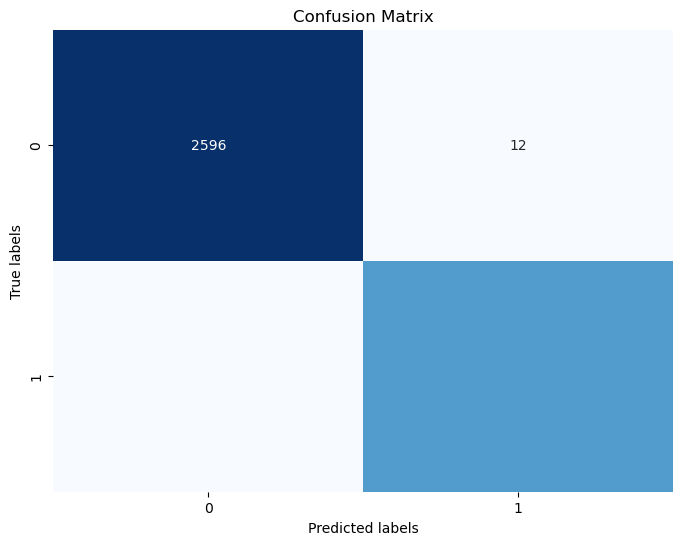

In [41]:
# Confusion Matrix
#cm = confusion_matrix(y_test, y_pred_nn)
#plt.figure(figsize=(8, 6))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')
#plt.title('Confusion Matrix')
#plt.show()

In [42]:
# Plot training history
#plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.title('Training and Validation Loss')
#plt.show()

NameError: name 'history' is not defined

In [ ]:
#plt.plot(history.history['accuracy'], label='Train Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.title('Training and Validation Accuracy')
#plt.show()


In [43]:
# ROC-AUC
#test_loss, test_acc, test_recall, test_precision, test_auc = lstm_model.evaluate(X_test_pad, y_test)
#print("Test Loss:", test_loss)
#print("Test Accuracy:", test_acc)
#print("Test Recall:", test_recall)
#print("Test Precision:", test_precision)
#print("Test AUC:", test_auc)


130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - AUC: 0.9994 - Precision: 0.9943 - Recall: 0.9926 - accuracy: 0.9953 - loss: 0.2936
Test Loss: 0.29577547311782837
Test Accuracy: 0.9946743845939636
Test Recall: 0.9921311736106873
Test Precision: 0.9934340119361877
Test AUC: 0.9990968108177185


In [44]:
y_pred_proba = lstm_model.predict(X_test_pad)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)
print("Test ROC-AUC:", roc_auc_value)


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step
Test ROC-AUC: 0.9992431993683761


In [45]:
# SHAP
def predict_fn(X):
    return lstm_model.predict(X).flatten()



In [46]:
background = X_train_pad[:100].astype(np.float32)
explainer = shap.KernelExplainer(predict_fn, background)
shap_values = explainer.shap_values(X_test_pad[:10].astype(np.float32))


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2551s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 2616s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
 9773/12969 ━━━━━━━━━━━━━━━━━━━━ 10:34 198ms/step

KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, X_test_pad[:10])



In [47]:
# LIME
explainer = LimeTextExplainer(class_names=['negative', 'positive'])
idx = 0
sample_text = df['clean_text'].iloc[idx]


In [48]:
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return np.array([[1-p, p] for p in lstm_model.predict(padded).flatten()])



In [50]:
input_dim = len(tokenizer.word_index) + 1
output_dim = 100
max_sequence_length = X_pad.shape[1]

In [51]:
exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)
exp.show_in_notebook(text=sample_text)


157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step


In [52]:
# Integrated Gradients - Explainability
ig = IntegratedGradients()
tokenizer_seq = tokenizer.texts_to_sequences(df['clean_text'])
text_input = tf.keras.preprocessing.sequence.pad_sequences(tokenizer_seq, padding='post', maxlen=max_sequence_length)
inputs = tf.convert_to_tensor(text_input, dtype=tf.float32)
predictions = lstm_model(inputs)
explanation = ig.attribute(inputs, target=predictions[:, 0], n_steps=50)



TypeError: IntegratedGradients.__init__() missing 1 required positional argument: 'forward_func'

In [ ]:
# Visualization of Integrated Gradients
viz.visualize_text([explanation.numpy()], text_input, ['positive', 'negative'], method_name='Integrated Gradients')
plt.show()


In [53]:
# Function to predict probabilities for LIME explainer
def predict_proba(texts):
    seq = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_sequence_length)
    preds = lstm_model.predict(padded)
    return np.hstack((1 - preds, preds))



In [54]:
# Initialize LIME text explainer
explainer = LimeTextExplainer(class_names=['Non-Generated', 'Generated'])



In [55]:
# Choose an example text to explain
idx = 0  # Change this index to select different examples
text_to_explain = df['clean_text'].iloc[idx]
true_label = df['generated'].iloc[idx]



In [56]:
# Explain the prediction of the example text
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=10)



157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


In [57]:
# Visualize the explanation
exp.show_in_notebook(text=True)



In [58]:
# Save the explanation as an HTML file
exp.save_to_file('lime_explanation.html')



In [59]:
# For terminal visualization
print('Document id: %d' % idx)
print('Probability(G):', predict_proba([text_to_explain])[0, 1])
print('True class: %s' % true_label)
exp.show_in_notebook(text=True)



Document id: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Probability(G): 0.6657024
True class: 1


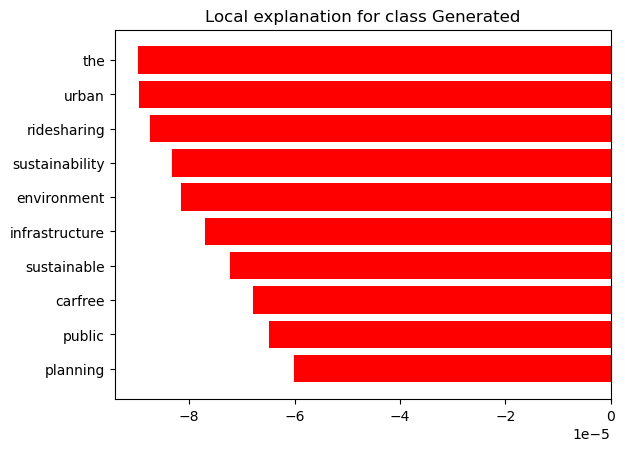

In [60]:
# Plot LIME explanations as a bar chart
fig = exp.as_pyplot_figure()
plt.show()

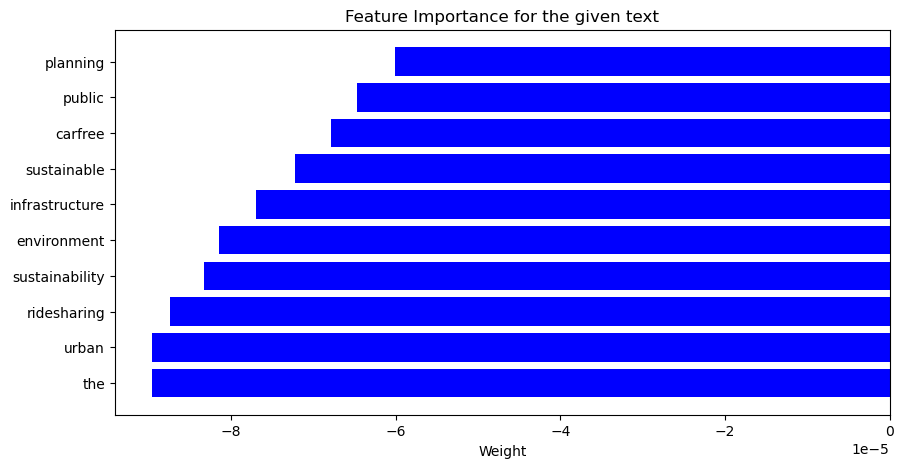

In [61]:
# 1. Feature Importance Bar Chart
plt.figure(figsize=(10, 5))
exp.as_list()
weights = dict(exp.as_list())
plt.barh(list(weights.keys()), list(weights.values()), color='b')
plt.xlabel('Weight')
plt.title('Feature Importance for the given text')
plt.show()



In [62]:
# 2. Explanation Heatmap
tokens = exp.as_map()[1]
heatmap = np.zeros(max_sequence_length)
for t, w in tokens:
    heatmap[t] = w



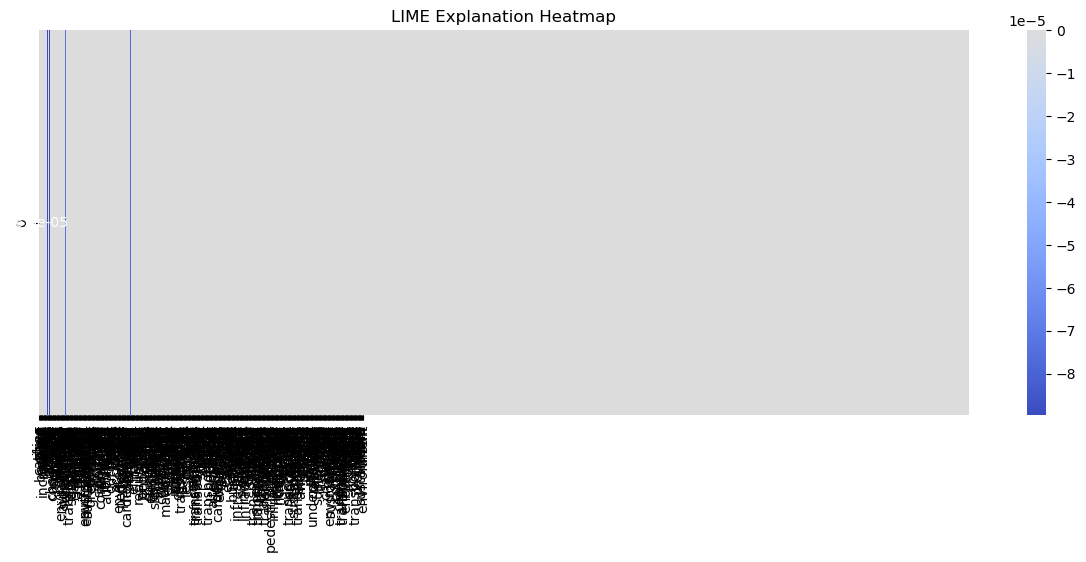

In [63]:
plt.figure(figsize=(15, 5))
sns.heatmap([heatmap], annot=True, xticklabels=tokenizer.sequences_to_texts([X_seq[idx]])[0].split(), cmap='coolwarm', center=0)
plt.title('LIME Explanation Heatmap')
plt.show()



157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step


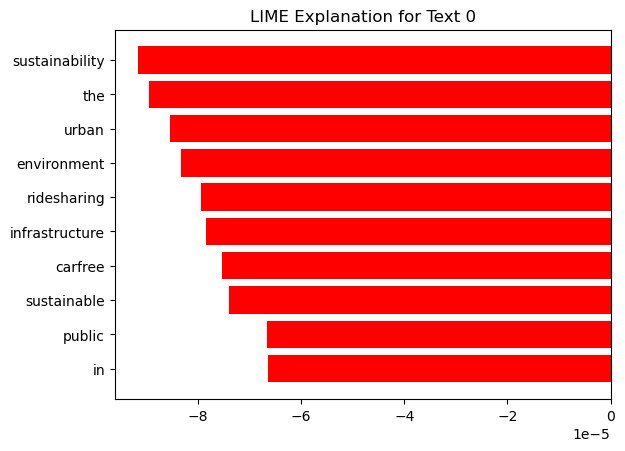

157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step


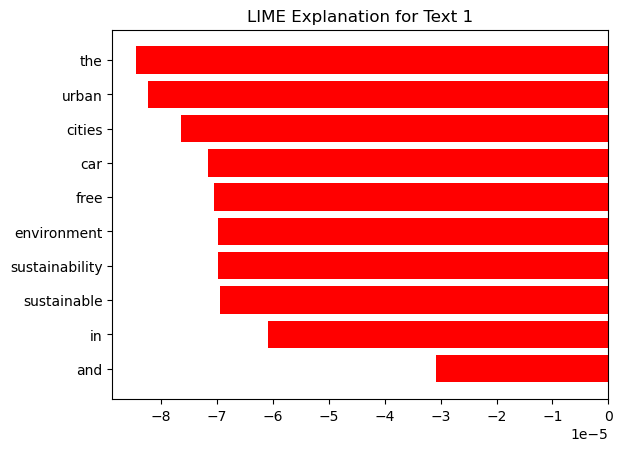

157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step


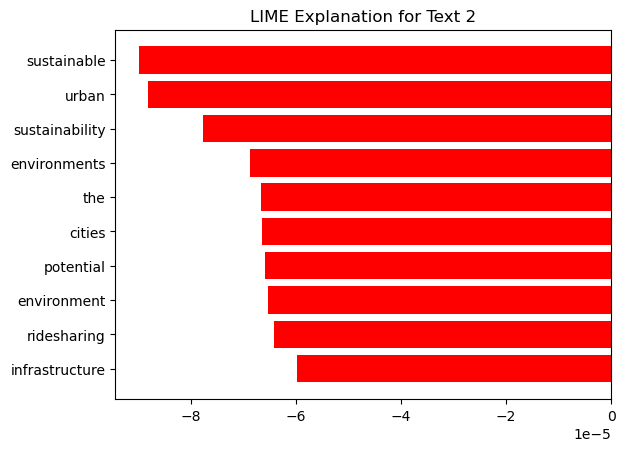

157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step


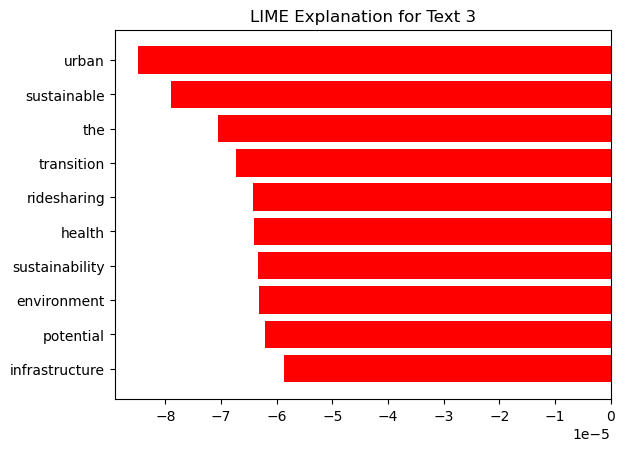

157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step


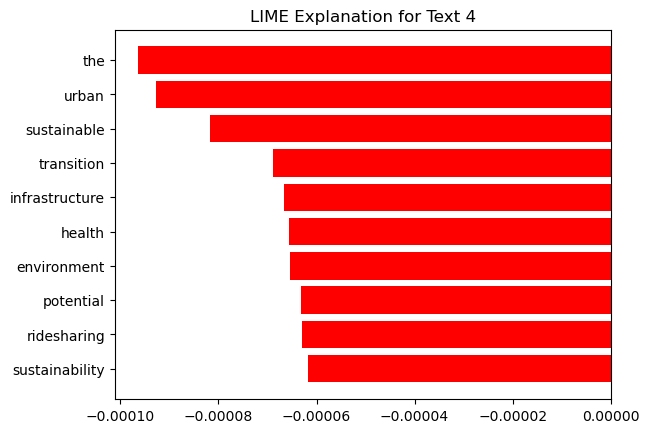

In [64]:
# 3. Comparison of Predictions for Multiple Texts
texts_to_explain = df['clean_text'].iloc[:5]  # Change to select different examples
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Text {i}')
    plt.show()

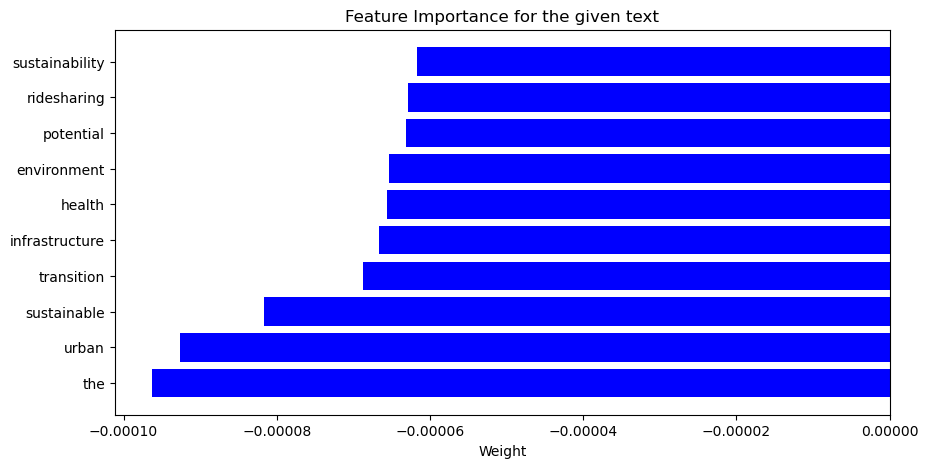

In [65]:
# Additional Visualizations

# 1. Feature Importance Bar Chart
plt.figure(figsize=(10, 5))
exp.as_list()
weights = dict(exp.as_list())
plt.barh(list(weights.keys()), list(weights.values()), color='b')
plt.xlabel('Weight')
plt.title('Feature Importance for the given text')
plt.show()



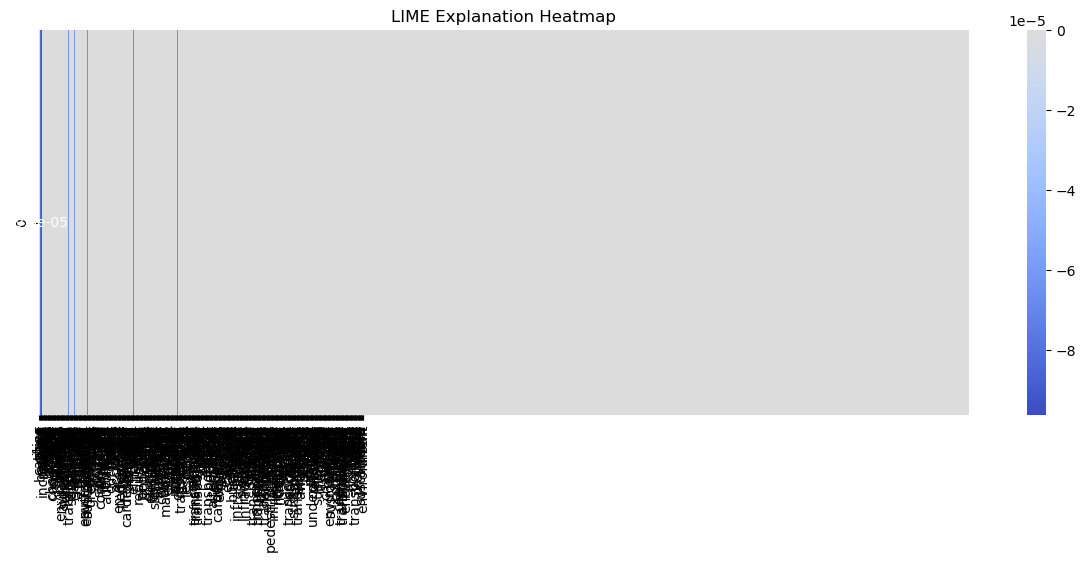

In [66]:
# 2. Explanation Heatmap
tokens = exp.as_map()[1]
heatmap = np.zeros(max_sequence_length)
for t, w in tokens:
    heatmap[t] = w

plt.figure(figsize=(15, 5))
sns.heatmap([heatmap], annot=True, xticklabels=tokenizer.sequences_to_texts([X_seq[idx]])[0].split(), cmap='coolwarm', center=0)
plt.title('LIME Explanation Heatmap')
plt.show()



157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step


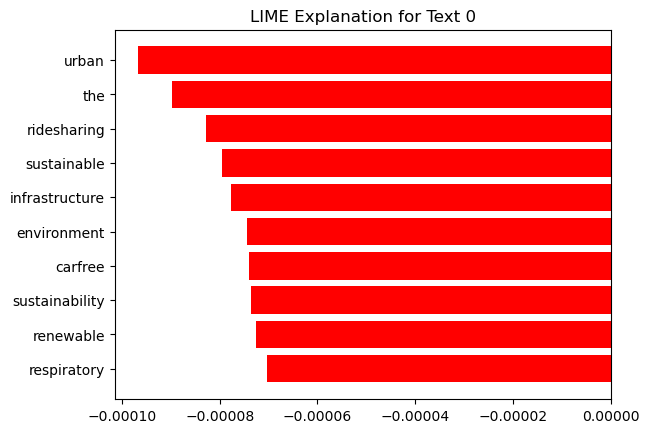

157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step


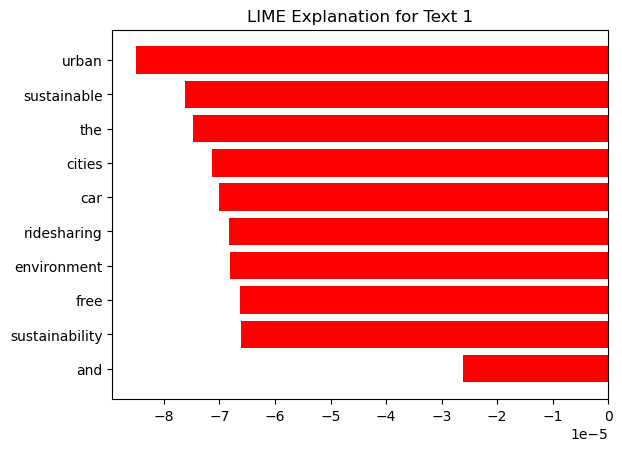

157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step


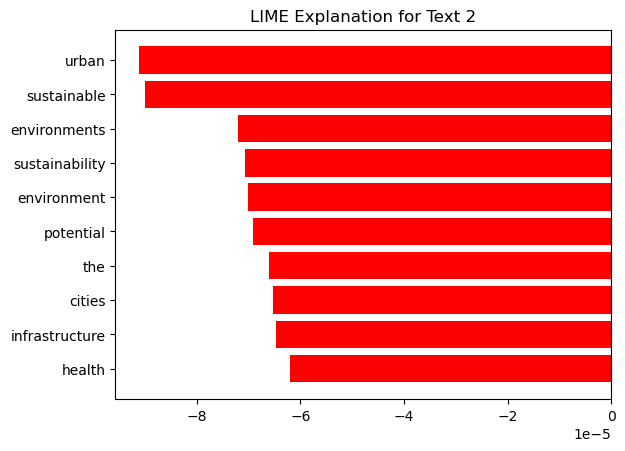

157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step


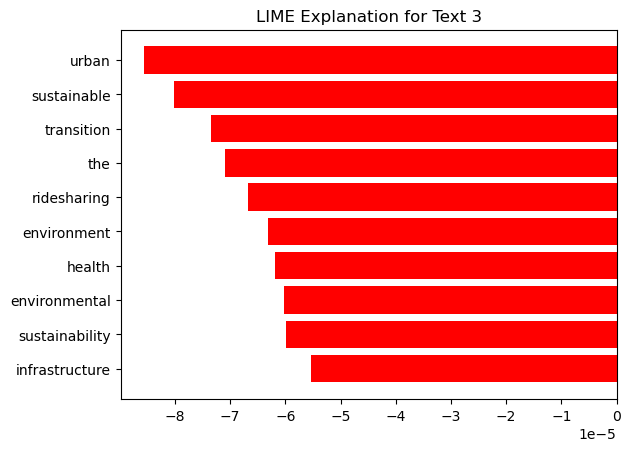

157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step


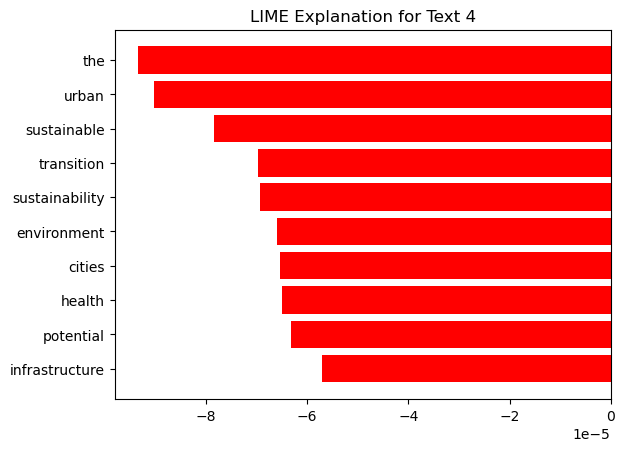

In [67]:
# 3. Comparison of Predictions for Multiple Texts
texts_to_explain = df['clean_text'].iloc[:5]  # Change to select different examples
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Text {i}')
    plt.show()



In [71]:
!pip install wordcloud

In [75]:
import wordcloud

In [77]:
# 4. Word Cloud of Important Features
word_weights = dict(exp.as_list())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Important Features')
plt.show()



NameError: name 'WordCloud' is not defined

130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step


C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


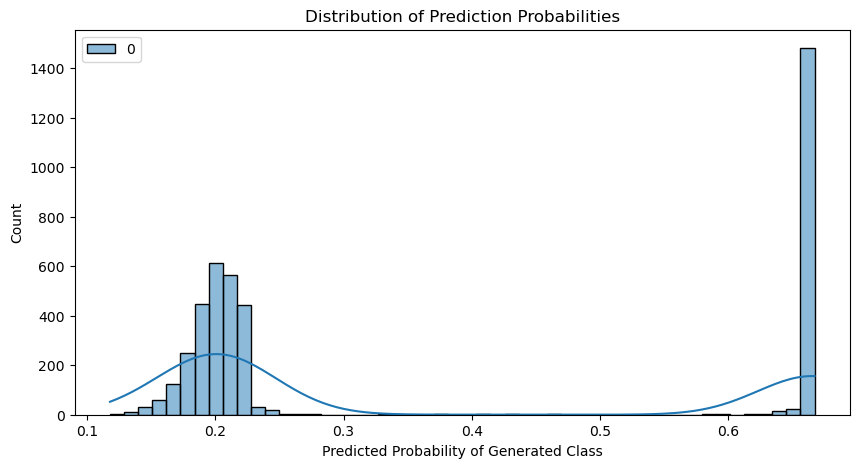

In [78]:
# 5. Distribution of Prediction Probabilities
y_pred_proba = lstm_model.predict(X_test_pad)
plt.figure(figsize=(10, 5))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.xlabel('Predicted Probability of Generated Class')
plt.title('Distribution of Prediction Probabilities')
plt.show()



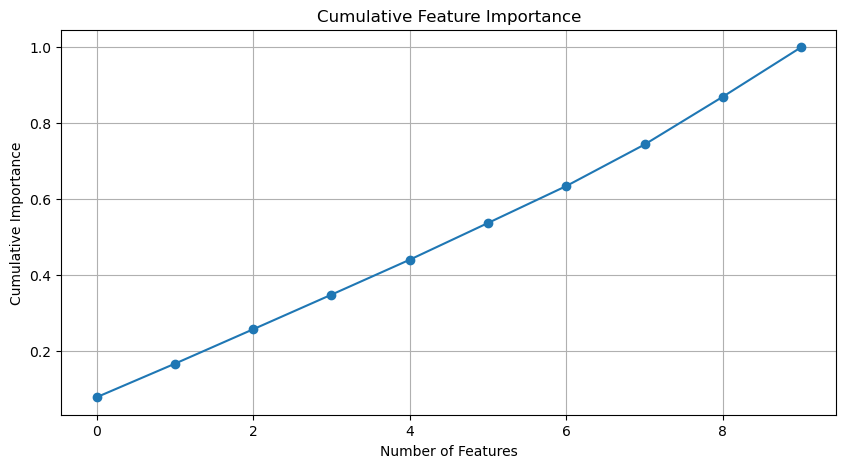

In [79]:
# 6. Cumulative Feature Importance
sorted_weights = sorted(word_weights.values(), reverse=True)
cumulative_importance = np.cumsum(sorted_weights) / np.sum(sorted_weights)
plt.figure(figsize=(10, 5))
plt.plot(cumulative_importance, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 229ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step


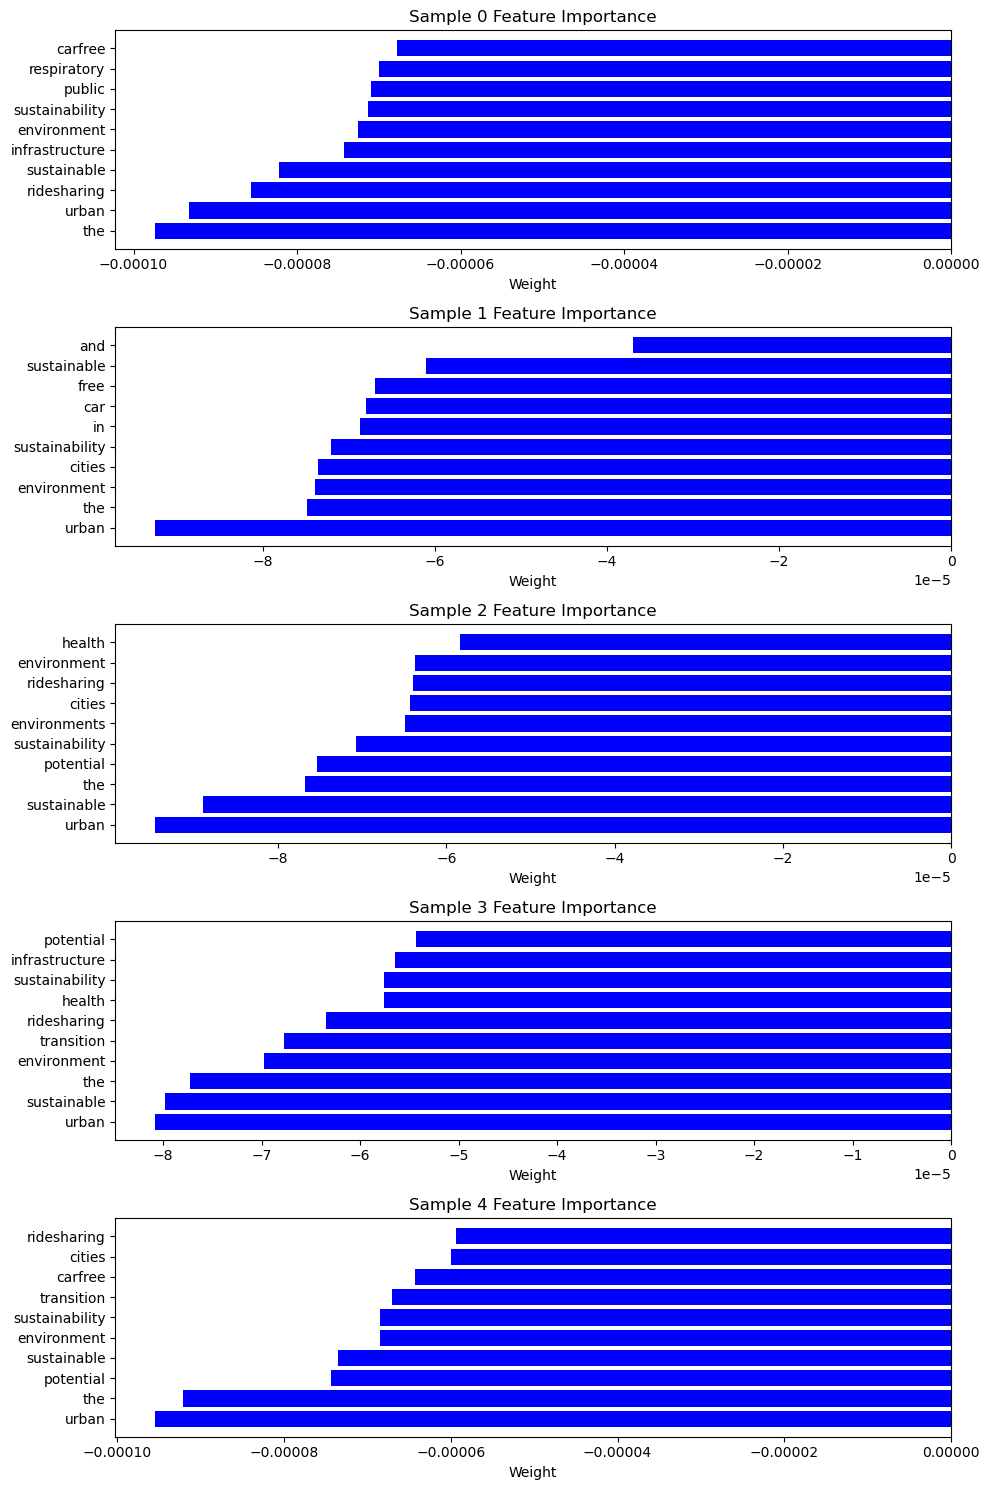

In [80]:
# 7. Feature Contribution Bar Chart for Multiple Samples
num_samples = 5
texts_to_explain = df['clean_text'].iloc[:num_samples]  # Change to select different examples
fig, axes = plt.subplots(num_samples, 1, figsize=(10, 15))
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    weights = dict(exp.as_list())
    axes[i].barh(list(weights.keys()), list(weights.values()), color='b')
    axes[i].set_title(f'Sample {i} Feature Importance')
    axes[i].set_xlabel('Weight')
fig.tight_layout()
plt.show()



157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step


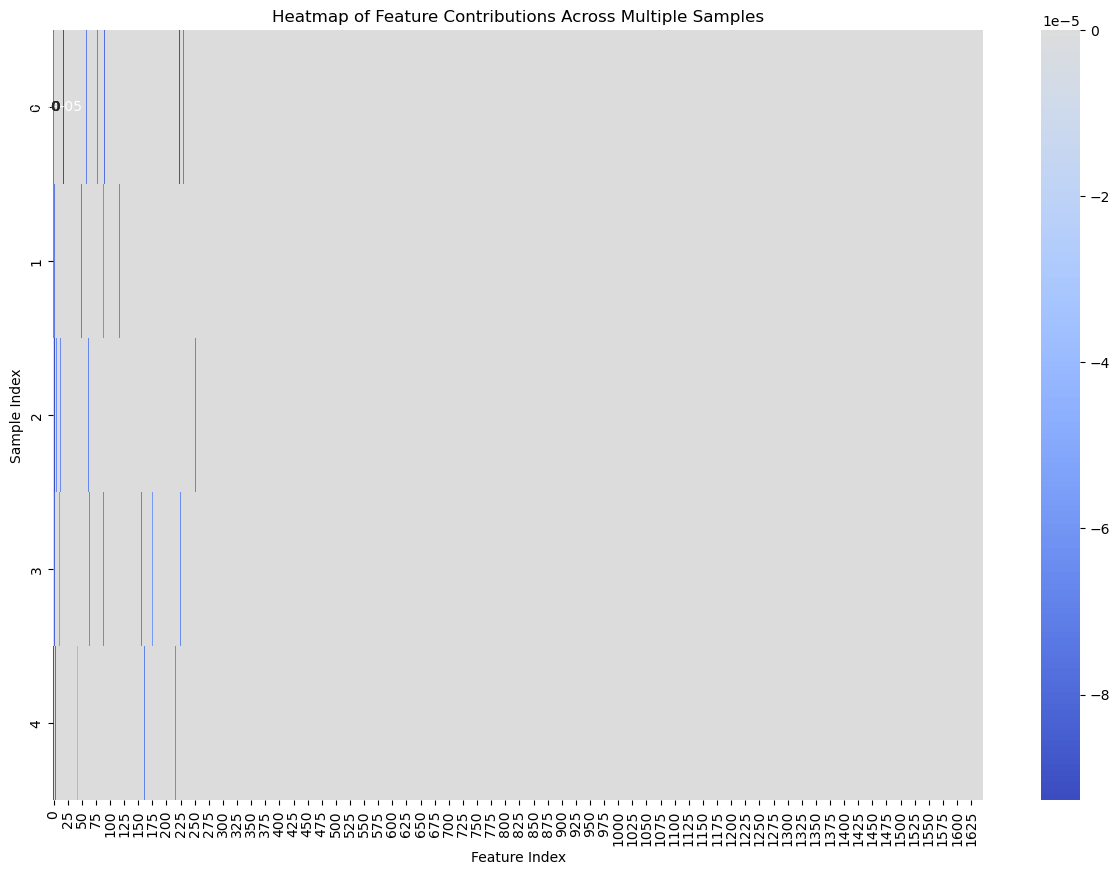

In [81]:
# 8. Heatmap of Feature Contributions Across Multiple Samples
num_samples = 5
texts_to_explain = df['clean_text'].iloc[:num_samples]  # Change to select different examples
feature_contributions = np.zeros((num_samples, max_sequence_length))
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    tokens = exp.as_map()[1]
    for t, w in tokens:
        feature_contributions[i, t] = w

plt.figure(figsize=(15, 10))
sns.heatmap(feature_contributions, annot=True, cmap='coolwarm', center=0)
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')
plt.title('Heatmap of Feature Contributions Across Multiple Samples')
plt.show()



157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s

C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


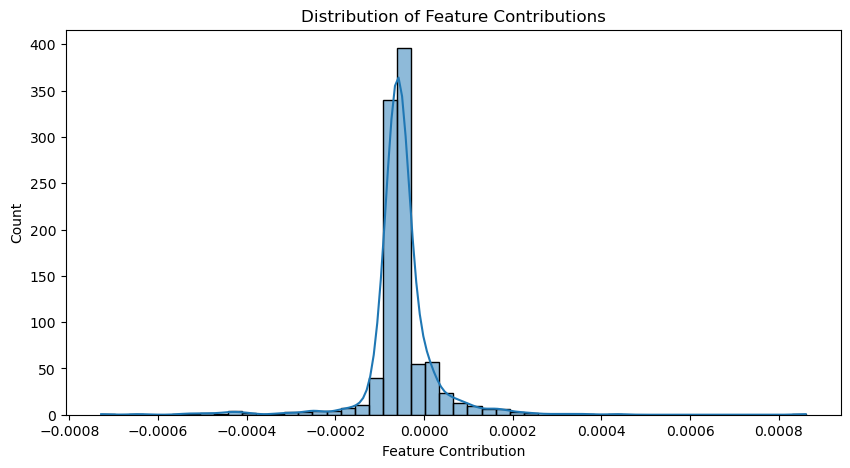

In [82]:
# 9. Feature Contribution Distribution
feature_contributions = []
for text in df['clean_text'].iloc[:100]:  # Change to analyze more samples
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    weights = dict(exp.as_list())
    feature_contributions.extend(list(weights.values()))

plt.figure(figsize=(10, 5))
sns.histplot(feature_contributions, bins=50, kde=True)
plt.xlabel('Feature Contribution')
plt.title('Distribution of Feature Contributions')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


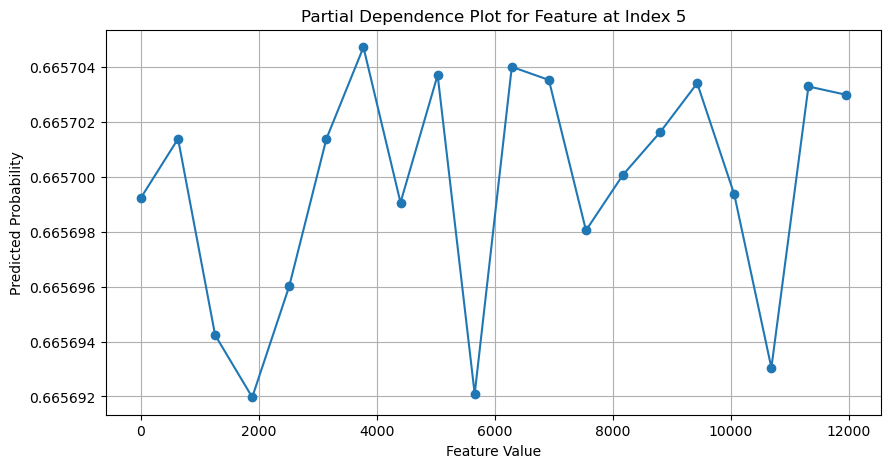

In [83]:
# 10. Partial Dependence Plot
def partial_dependence_plot(text, feature_index):
    seq = tokenizer.texts_to_sequences([text])[0]
    feature_values = np.linspace(0, np.max(seq), num=20).astype(int)
    predictions = []
    for value in feature_values:
        temp_seq = seq.copy()
        temp_seq[feature_index] = value
        padded = tf.keras.preprocessing.sequence.pad_sequences([temp_seq], maxlen=max_sequence_length)
        preds = lstm_model.predict(padded)
        predictions.append(preds[0][0])
    
    plt.figure(figsize=(10, 5))
    plt.plot(feature_values, predictions, marker='o')
    plt.xlabel('Feature Value')
    plt.ylabel('Predicted Probability')
    plt.title(f'Partial Dependence Plot for Feature at Index {feature_index}')
    plt.grid()
    plt.show()

partial_dependence_plot(text_to_explain, 5)  # Change the feature index to analyze different features



157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step


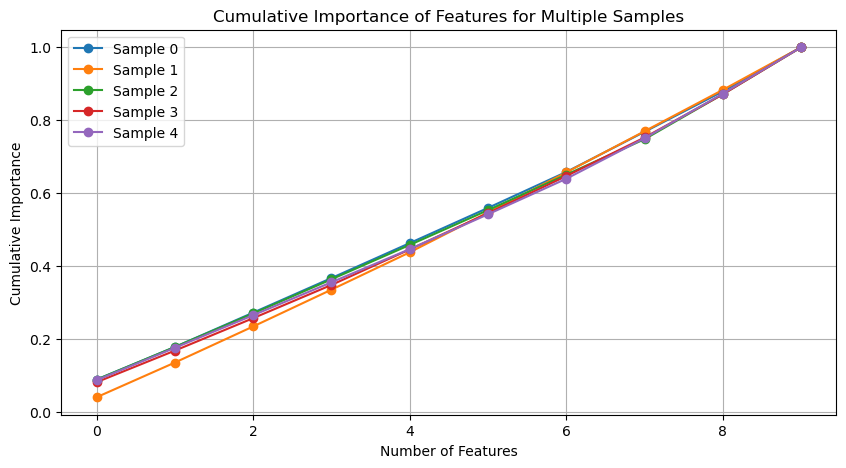

In [84]:
# 11. Cumulative Importance of Features for Multiple Samples
num_samples = 5
texts_to_explain = df['clean_text'].iloc[:num_samples]  # Change to select different examples
cumulative_importances = []
for text in texts_to_explain:
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    weights = sorted(dict(exp.as_list()).values(), reverse=True)
    cumulative_importance = np.cumsum(weights) / np.sum(weights)
    cumulative_importances.append(cumulative_importance)

plt.figure(figsize=(10, 5))
for i, cum_importance in enumerate(cumulative_importances):
    plt.plot(cum_importance, marker='o', label=f'Sample {i}')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importance of Features for Multiple Samples')
plt.legend()
plt.grid()
plt.show()

In [87]:
# Function to predict classes for Anchor explainer
def predict_fn(texts):
    seq = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_sequence_length)
    preds = lstm_model.predict(padded)
    return (preds > 0.5).astype(int)



In [91]:
!pip install anchor

  Using cached anchor-0.4.0-py3-none-any.whl
  Using cached WebOb-1.8.7-py2.py3-none-any.whl.metadata (10 kB)
  Using cached pecan-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached Paste-3.10.1-py3-none-any.whl.metadata (5.3 kB)
  Using cached netaddr-1.3.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached ldap3-2.9.1-py2.py3-none-any.whl.metadata (5.4 kB)
  Using cached stevedore-5.2.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached pycadf-3.1.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached oslo.config-9.4.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached oslo.messaging-14.8.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached oslo.utils-7.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached debtcollector-3.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached oslo.i18n-6.3.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached rfc3986-2.0.0-py2.py3-none-any.whl.metadata (6.6 kB)
  Using cached amqp-5.2.0-py3-none-any.whl.metadata (8.9 kB)
  Using cached futurist-3.0.0-py3-

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [19 lines of output]
  C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\setuptools\config\setupcfg.py:293: _DeprecatedConfig: Deprecated config in `setup.cfg`
  !!
  
          ********************************************************************************
          The license_file parameter is deprecated, use license_files instead.
  
          This deprecation is overdue, please update your project and remove deprecated
          calls to avoid build errors in the future.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!
    parsed = self.parsers.get(option_name, lambda x: x)(value)
  running bdist_wheel
  running build
  running build_ext
  building 'netifaces' extension
  error: Microsoft Visual C++ 14.0 or 

In [92]:
import anchor
from anchor import anchor_text

ModuleNotFoundError: No module named 'anchor'

In [86]:
# Initialize Anchor text explainer
explainer = anchor_text.AnchorText(nlp=predict_fn)



NameError: name 'anchor_text' is not defined

In [ ]:
# Choose an example text to explain
idx = 0  # Change this index to select different examples
text_to_explain = df['clean_text'].iloc[idx]
true_label = df['generated'].iloc[idx]



In [ ]:
# Explain the prediction of the example text
exp = explainer.explain_instance(text_to_explain, predict_fn, threshold=0.95)



In [ ]:
# Visualize the explanation
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())
exp.show_in_notebook()



In [ ]:
# Save the explanation as an HTML file
exp.save_to_file('anchor_explanation.html')



In [ ]:
# Additional Visualizations

# 1. Single Explanation Plot
plt.figure(figsize=(10, 5))
plt.barh(exp.names(), exp.precision())
plt.xlabel('Precision')
plt.title('Anchor Explanation Precision')
plt.show()



In [ ]:
# 2. Multiple Explanations Plot
num_samples = 5
texts_to_explain = df['clean_text'].iloc[:num_samples]  # Change to select different examples
precisions = []
coverages = []
for text in texts_to_explain:
    exp = explainer.explain_instance(text, predict_fn, threshold=0.95)
    precisions.append(exp.precision())
    coverages.append(exp.coverage())

plt.figure(figsize=(10, 5))
plt.barh(range(num_samples), precisions, color='b', alpha=0.6, label='Precision')
plt.barh(range(num_samples), coverages, color='r', alpha=0.6, label='Coverage')
plt.xlabel('Value')
plt.ylabel('Sample Index')
plt.title('Anchor Precision and Coverage for Multiple Samples')
plt.legend()
plt.show()



In [ ]:
# 3. Anchor Coverage and Precision Plot
plt.figure(figsize=(10, 5))
plt.scatter(precisions, coverages, c='b', marker='o')
plt.xlabel('Precision')
plt.ylabel('Coverage')
plt.title('Anchor Coverage and Precision')
plt.grid()
plt.show()



In [ ]:
# 4. Word Cloud of Important Anchors
all_anchors = []
for text in df['clean_text'].iloc[:100]:  # Change to analyze more samples
    exp = explainer.explain_instance(text, predict_fn, threshold=0.95)
    all_anchors.extend(exp.names())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_anchors))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Important Anchors')
plt.show()



In [ ]:
# 5. Distribution of Anchor Length
anchor_lengths = []
for text in df['clean_text'].iloc[:100]:  # Change to analyze more samples
    exp = explainer.explain_instance(text, predict_fn, threshold=0.95)
    anchor_lengths.append(len(exp.names()))

plt.figure(figsize=(10, 5))
sns.histplot(anchor_lengths, bins=50, kde=True)
plt.xlabel('Anchor Length')
plt.title('Distribution of Anchor Lengths')
plt.show()

In [93]:
# Function to visualize attention weights
def visualize_attention_weights(model, text, tokenizer, max_seq_length):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_seq_length)
    
    # Get attention weights from the attention layer
    attention_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('attention').output)
    attention_weights = attention_model.predict(padded)[0]  # Assuming batch size 1
    
    # Plot heatmap of attention weights
    plt.figure(figsize=(10, 6))
    sns.heatmap(attention_weights, cmap='YlGnBu', xticklabels=text.split(), yticklabels=text.split(), annot=True, fmt='.2f')
    plt.title('Attention Heatmap')
    plt.xlabel('Words in Input Text')
    plt.ylabel('Words in Input Text')
    plt.show()



In [95]:
max_seq_length = 100

In [97]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [98]:
# Example usage: Visualize attention for a specific text
text_to_visualize = df['clean_text'].iloc[0]
visualize_attention_weights(lstm_model, text_to_visualize, tokenizer, max_seq_length)

ValueError: The layer sequential has never been called and thus has no defined input.

In [99]:
# Function to visualize attention weights
def visualize_attention_weights(model, text, tokenizer, max_seq_length):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_seq_length)
    
    # Get attention weights from the attention layer
    attention_model = Model(inputs=model.input, outputs=model.get_layer('attention').output)
    attention_weights = attention_model.predict(padded)[0]  # Assuming batch size 1
    
    # Plot heatmap of attention weights
    plt.figure(figsize=(10, 6))
    sns.heatmap(attention_weights, cmap='YlGnBu', xticklabels=text.split(), yticklabels=text.split(), annot=True, fmt='.2f')
    plt.title('Attention Heatmap')
    plt.xlabel('Words in Input Text')
    plt.ylabel('Words in Input Text')
    plt.show()



In [101]:
from tensorflow.keras.models import Sequential, Model

In [102]:
# Example usage: Visualize attention for a specific text
text_to_visualize = df['clean_text'].iloc[0]
visualize_attention_weights(lstm_model, text_to_visualize, tokenizer, max_seq_length)



ValueError: The layer sequential has never been called and thus has no defined input.

In [103]:
# Function to predict probabilities
def predict_proba(texts):
    seq = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seq, maxlen=max_seq_length)
    preds = lstm_model.predict(padded)
    return np.hstack((1 - preds, preds))



In [104]:
# Initialize LIME explainer
lime_explainer = LimeTextExplainer(class_names=['Not Generated', 'Generated'])



In [105]:
# Choose an example text to explain
idx = 0  # Change this index to select different examples
text_to_explain = df['clean_text'].iloc[idx]


In [106]:

# Explain the prediction of the example text using LIME
lime_exp = lime_explainer.explain_instance(text_to_explain, predict_proba, num_features=10)



InvalidArgumentError: Graph execution error:

Detected at node sequential_1/attention_3_1/add defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\Ahmedma\AppData\Local\Temp\ipykernel_11172\380493391.py", line 2, in <module>

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\lime\lime_text.py", line 413, in explain_instance

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\lime\lime_text.py", line 482, in __data_labels_distances

  File "C:\Users\Ahmedma\AppData\Local\Temp\ipykernel_11172\1216908564.py", line 5, in predict_proba

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 504, in predict

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 204, in one_step_on_data_distributed

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 194, in one_step_on_data

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 92, in predict_step

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Ahmedma\AppData\Local\Temp\ipykernel_11172\585312467.py", line 20, in call

Incompatible shapes: [32,100,1] vs. [1647,1]
	 [[{{node sequential_1/attention_3_1/add}}]] [Op:__inference_one_step_on_data_distributed_362853]

In [107]:
# Visualize the explanation
lime_exp.show_in_notebook()

NameError: name 'lime_exp' is not defined

In [108]:
# Function to calculate token importance using Integrated Gradients
def calculate_token_importance(model, text, tokenizer, max_seq_length):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_seq_length)
    
    # Initialize Integrated Gradients
    ig = IntegratedGradients(model)
    
    # Compute attributions
    attributions, delta = ig.attribute(padded, n_steps=50, return_convergence_delta=True)
    
    # Summarize attributions across all tokens
    token_importance = np.sum(attributions, axis=1).squeeze()
    
    return token_importance



In [109]:
# Example usage: Calculate token importance for a specific text
text_to_analyze = df['clean_text'].iloc[0]
token_importance = calculate_token_importance(lstm_model, text_to_analyze, tokenizer, max_seq_length)



AssertionError: `inputs` must be a torch.Tensor or a tuple[torch.Tensor] but found: <class 'numpy.ndarray'>

In [110]:
# Visualize token importance
top_k = 10  # Number of top tokens to visualize
sorted_indices = np.argsort(token_importance)
top_tokens = [tokenizer.index_word[idx] for idx in sorted_indices[-top_k:]]
top_scores = token_importance[sorted_indices[-top_k:]]



NameError: name 'token_importance' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_tokens, palette='viridis')
plt.xlabel('Token Importance Score')
plt.ylabel('Top Tokens')
plt.title('Top Tokens by Importance Score')
plt.show()

In [111]:
# Function to calculate token importance using Integrated Gradients
def calculate_token_importance(model, text, tokenizer, max_seq_length):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_seq_length)
    
    # Initialize Integrated Gradients
    ig = IntegratedGradients(model)
    
    # Compute attributions
    attributions, delta = ig.attribute(padded, n_steps=50, return_convergence_delta=True)
    
    # Summarize attributions across all tokens
    token_importance = np.sum(attributions, axis=1).squeeze()
    
    return token_importance


In [112]:

# Example usage: Calculate token importance for a specific text
text_to_analyze = df['clean_text'].iloc[0]
token_importance = calculate_token_importance(lstm_model, text_to_analyze, tokenizer, max_seq_length)



AssertionError: `inputs` must be a torch.Tensor or a tuple[torch.Tensor] but found: <class 'numpy.ndarray'>

In [113]:
# Visualize token importance
top_k = 10  # Number of top tokens to visualize
sorted_indices = np.argsort(token_importance)
top_tokens = [tokenizer.index_word[idx] for idx in sorted_indices[-top_k:]]
top_scores = token_importance[sorted_indices[-top_k:]]



NameError: name 'token_importance' is not defined

In [114]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_tokens, palette='viridis')
plt.xlabel('Token Importance Score')
plt.ylabel('Top Tokens')
plt.title('Top Tokens by Importance Score')
plt.show()

NameError: name 'top_scores' is not defined

<Figure size 1000x600 with 0 Axes>

In [115]:
# Function to calculate token importance using Integrated Gradients for multiple texts
def calculate_token_importance_multiple(model, texts, tokenizer, max_seq_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
    
    # Initialize Integrated Gradients
    ig = IntegratedGradients(model)
    
    # Compute attributions for each text
    attributions_list = []
    for seq in padded_sequences:
        attributions, _ = ig.attribute(seq.reshape(1, -1), n_steps=50, return_convergence_delta=True)
        attributions_list.append(attributions.squeeze())
    
    # Convert to numpy array and aggregate across texts
    attributions_array = np.array(attributions_list)
    aggregated_attributions = np.sum(attributions_array, axis=0)
    
    return aggregated_attributions



In [116]:
# Example usage: Calculate token importance for multiple texts
texts_to_analyze = df['clean_text'].sample(n=100, random_state=42)  # Example: analyze 100 random texts
token_importance = calculate_token_importance_multiple(lstm_model, texts_to_analyze, tokenizer, max_seq_length)



AssertionError: `inputs` must be a torch.Tensor or a tuple[torch.Tensor] but found: <class 'numpy.ndarray'>

In [117]:
# Visualize aggregated token importance
top_k = 20  # Number of top tokens to visualize
sorted_indices = np.argsort(token_importance)
top_tokens = [tokenizer.index_word[idx] for idx in sorted_indices[-top_k:]]
top_scores = token_importance[sorted_indices[-top_k:]]



NameError: name 'token_importance' is not defined

In [118]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_tokens, palette='viridis')
plt.xlabel('Token Importance Score')
plt.ylabel('Top Tokens')
plt.title('Top Tokens by Aggregate Importance Score')
plt.show()

NameError: name 'top_scores' is not defined

<Figure size 1000x600 with 0 Axes>

In [119]:
# Function to calculate token importance using Integrated Gradients for multiple texts and classes
def calculate_token_importance_multiple_classes(model, texts, tokenizer, max_seq_length, num_classes):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
    
    # Initialize Integrated Gradients
    ig = IntegratedGradients(model)
    
    # Compute attributions for each text and each class
    attributions_by_class = []
    for seq in padded_sequences:
        attributions_list = []
        for class_idx in range(num_classes):
            class_label = np.array([class_idx])
            attributions, _ = ig.attribute(seq.reshape(1, -1), target=class_label, n_steps=50, return_convergence_delta=True)
            attributions_list.append(attributions.squeeze())
        attributions_by_class.append(attributions_list)
    
    # Convert to numpy array and aggregate across texts and classes
    attributions_array = np.array(attributions_by_class)
    aggregated_attributions = np.sum(attributions_array, axis=0)
    
    return aggregated_attributions



In [120]:
# Example usage: Calculate token importance for multiple texts and classes
texts_to_analyze = df['clean_text'].sample(n=100, random_state=42)  # Example: analyze 100 random texts
num_classes = len(np.unique(df['generated']))  # Number of unique classes



In [121]:
token_importance = calculate_token_importance_multiple_classes(lstm_model, texts_to_analyze, tokenizer, max_seq_length, num_classes)



AssertionError: `inputs` must be a torch.Tensor or a tuple[torch.Tensor] but found: <class 'numpy.ndarray'>

In [122]:
# Visualize aggregated token importance for each class
top_k = 20  # Number of top tokens to visualize
class_labels = np.unique(df['generated'])



In [123]:
plt.figure(figsize=(12, 8))
for i, class_label in enumerate(class_labels):
    sorted_indices = np.argsort(token_importance[i])
    top_tokens = [tokenizer.index_word[idx] for idx in sorted_indices[-top_k:]]
    top_scores = token_importance[i][sorted_indices[-top_k:]]
    
    plt.subplot(2, 3, i + 1)
    sns.barplot(x=top_scores, y=top_tokens, palette='viridis')
    plt.xlabel('Token Importance Score')
    plt.ylabel('Top Tokens')
    plt.title(f'Top Tokens for Class {class_label}')
    


NameError: name 'token_importance' is not defined

<Figure size 1200x800 with 0 Axes>

In [124]:
plt.tight_layout()
plt.show()



<Figure size 640x480 with 0 Axes>

In [125]:
# Statistical validation: Perform t-test between token importance scores of different classes
class_1_importance = token_importance[0]  # Example: token importance scores for class 1
class_2_importance = token_importance[1]  # Example: token importance scores for class 2



NameError: name 'token_importance' is not defined

In [126]:
t_stat, p_value = ttest_ind(class_1_importance, class_2_importance)
print(f"T-test p-value between Class 1 and Class 2: {p_value:.4f}")

NameError: name 'ttest_ind' is not defined

In [127]:
# Function to calculate token importance using Integrated Gradients for multiple texts and classes
def calculate_token_importance_multiple_classes(model, texts, tokenizer, max_seq_length, num_classes):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
    
    # Initialize Integrated Gradients
    ig = IntegratedGradients(model)
    
    # Compute attributions for each text and each class
    attributions_by_class = []
    for seq in padded_sequences:
        attributions_list = []
        for class_idx in range(num_classes):
            class_label = np.array([class_idx])
            attributions, _ = ig.attribute(seq.reshape(1, -1), target=class_label, n_steps=50, return_convergence_delta=True)
            attributions_list.append(attributions.squeeze())
        attributions_by_class.append(attributions_list)
    
    # Convert to numpy array and aggregate across texts and classes
    attributions_array = np.array(attributions_by_class)
    aggregated_attributions = np.sum(attributions_array, axis=0)
    
    return aggregated_attributions



In [128]:
# Example usage: Calculate token importance for multiple texts and classes
texts_to_analyze = df['clean_text'].sample(n=100, random_state=42)  # Example: analyze 100 random texts
num_classes = len(np.unique(df['generated']))  # Number of unique classes



In [129]:
token_importance = calculate_token_importance_multiple_classes(lstm_model, texts_to_analyze, tokenizer, max_seq_length, num_classes)



AssertionError: `inputs` must be a torch.Tensor or a tuple[torch.Tensor] but found: <class 'numpy.ndarray'>

In [130]:
# Bootstrap method for confidence intervals
n_bootstrap_samples = 100  # Number of bootstrap samples
bootstrap_importance = np.zeros_like(token_importance)



NameError: name 'token_importance' is not defined

In [ ]:
for i in range(token_importance.shape[0]):
    bootstrapped_scores = []
    for _ in range(n_bootstrap_samples):
        resampled_data = resample(token_importance[i], replace=True, n_samples=len(token_importance[i]))
        bootstrapped_scores.append(resampled_data)
    bootstrapped_scores = np.array(bootstrapped_scores)
    
    # Calculate confidence intervals
    confidence_interval = np.percentile(bootstrapped_scores, [2.5, 97.5], axis=0)
    bootstrap_importance[i] = confidence_interval[1] - confidence_interval[0]



In [ ]:
# Visualize aggregated token importance for each class with confidence intervals
top_k = 20  # Number of top tokens to visualize
class_labels = np.unique(df['generated'])



In [ ]:
plt.figure(figsize=(12, 8))
for i, class_label in enumerate(class_labels):
    sorted_indices = np.argsort(token_importance[i])
    top_tokens = [tokenizer.index_word[idx] for idx in sorted_indices[-top_k:]]
    top_scores = token_importance[i][sorted_indices[-top_k:]]
    confidence_intervals = bootstrap_importance[i][sorted_indices[-top_k:]]
    
    plt.subplot(2, 3, i + 1)
    plt.errorbar(top_scores, range(len(top_scores)), xerr=confidence_intervals, fmt='o', color='b', elinewidth=1, capsize=3)
    plt.yticks(range(len(top_tokens)), top_tokens)
    plt.xlabel('Token Importance Score')
    plt.title(f'Top Tokens for Class {class_label} with Confidence Intervals')
    


In [ ]:
plt.tight_layout()
plt.show()

In [131]:
!pip install lime captum


In [132]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from lime.lime_text import LimeTextExplainer

# Integrated Gradients for token importance
def compute_integrated_gradients(model, text_sequence):
    ig = IntegratedGradients(model)
    attributions, _ = ig.attribute(text_sequence, return_convergence_delta=True)
    return attributions.numpy().squeeze()

# LIME for local explanations
def compute_lime_explanation(model, text, tokenizer):
    explainer = LimeTextExplainer(class_names=['0', '1'])  # Adjust class names based on your problem
    text_sequence = tokenizer.texts_to_sequences([text])[0]
    exp = explainer.explain_instance(text, model.predict_proba, num_features=len(text_sequence))
    return exp.as_list()


In [133]:
# Example text
sample_text = "example text for analysis"

# Tokenize text
text_sequence = tokenizer.texts_to_sequences([sample_text])
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=max_sequence_length)

# Compute Integrated Gradients
integrated_gradients = compute_integrated_gradients(lstm_model, padded_sequence)

# Compute LIME explanation
lime_explanation = compute_lime_explanation(lstm_model, sample_text, tokenizer)

# Display results
print("Integrated Gradients:")
print(integrated_gradients)

print("\nLIME Explanation:")
print(lime_explanation)


AssertionError: `inputs` must be a torch.Tensor or a tuple[torch.Tensor] but found: <class 'numpy.ndarray'>

In [134]:
# Plot Integrated Gradients scores
plt.figure(figsize=(10, 6))
plt.barh(range(len(integrated_gradients)), integrated_gradients)
plt.yticks(range(len(integrated_gradients)), tokenizer.word_index.keys())
plt.xlabel('Integrated Gradients Score')
plt.ylabel('Tokens')
plt.title('Token Importance Scores (Integrated Gradients)')
plt.show()

# Plot LIME explanation
lime_features = dict(lime_explanation)
lime_features = {k: v for k, v in lime_features.items() if k in tokenizer.word_index}
lime_scores = [lime_features.get(tokenizer.index_word[i], 0) for i in range(1, len(tokenizer.word_index) + 1)]

plt.figure(figsize=(10, 6))
plt.barh(range(len(lime_scores)), lime_scores)
plt.yticks(range(len(lime_scores)), tokenizer.word_index.keys())
plt.xlabel('LIME Score')
plt.ylabel('Tokens')
plt.title('Token Importance Scores (LIME)')
plt.show()


NameError: name 'integrated_gradients' is not defined

<Figure size 1000x600 with 0 Axes>